In [1]:
import pandas                  as pd
from   scipy import stats
import numpy                   as np
import matplotlib.pyplot       as plt
import seaborn                 as sns
import statsmodels.formula.api as sm
import chart_studio.plotly     as py
from sklearn import linear_model
from sklearn.model_selection import GridSearchCV
# https://community.plot.ly/t/solved-update-to-plotly-4-0-0-broke-application/26526/2
import os

import plotly.express    as px
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [2]:
#IMPORTAMOS BASE DE DATOS 1
bd=pd.read_excel(r'C:\Users\garro\OneDrive\Escritorio\DATA SCIENCE\TRABAJO PRACTICO\ViolenciaGenero2.3.xlsx', sheet_name='casos')

#CAMBIAMOS FORMATO DE LA COLUMNA FECHA A 'DATETIME'
bd['FECHA']=pd.to_datetime(bd.FECHA, errors='coerce')

#LIMPIEZA DE VALORES NULOS. REEMPLAZO POR MEDIA
bd['EDAD']= bd['EDAD'].fillna(method='bfill')

#REMOCION DE OUTLIERS
def remove_outliers(df, column_name):
    q1 = df[column_name].quantile(0.25)
    q3 = df[column_name].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    df = df.loc[(df[column_name]>=lower_bound) & (df[column_name] <= upper_bound)]
    return df
bd = remove_outliers(bd, 'EDAD')
bd.head()

,FECHA,PROVINCIA,GENERO_PERSONA_SIT_VIOLENCIA,EDAD,PAIS_NACIMIENTO,VIOLENCIA_FISICA,VIOLENCIA_PSICOLOGICA,VIOLENCIA_SEXUAL,VIOLENCIA_ECONOMICA,VIOLENCIA_SIMBOLICA,...,VIOLENCIA_INSTITUCIONAL,VIOLENCIA_LABORAL,VIOLENCIA_CONTRA_LIBERTAD_REPRODUCTIVA,VIOLENCIA_OTRAS,VINCULO_PERSONA_AGRESORA,GENERO_AGRESOR,CASO,TiPO_VIOLENCIA,LUGAR_VIOLENCIA,MOTIVO_VIOLENCIA
0,2020-01-01,Tucumán,Mujer,39.0,NaN,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,Pareja,Varon,1.0,VIOLENCIA_FISICA,VIOLENCIA_DOMESTICA,VIOLENCIA_OTRAS
1,2020-01-01,Buenos Aires,Mujer,39.0,NaN,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,Ex pareja,Varon,1.0,VIOLENCIA_FISICA,VIOLENCIA_DOMESTICA,VIOLENCIA_OTRAS
2,2020-01-01,Buenos Aires,Mujer,22.0,Argentina,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,Ex pareja,Varon,1.0,VIOLENCIA_FISICA,VIOLENCIA_DOMESTICA,VIOLENCIA_OTRAS
3,2020-01-01,Buenos Aires,Mujer,53.0,NaN,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,Pareja,Varon,1.0,VIOLENCIA_PSICOLOGICA,VIOLENCIA_DOMESTICA,VIOLENCIA_OTRAS
4,2020-01-01,Buenos Aires,Mujer,38.0,Argentina,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,Pareja,Varon,1.0,VIOLENCIA_FISICA,VIOLENCIA_DOMESTICA,VIOLENCIA_OTRAS


In [3]:
from sklearn.preprocessing import LabelEncoder
# Crear una instancia del codificador de etiquetas
label_encoder = LabelEncoder()

# Codificar la columna de vínculos utilizando Label Encoding
bd['VINCULO_ENCODED'] = label_encoder.fit_transform(bd['VINCULO_PERSONA_AGRESORA'])

# Seleccionar las columnas de edades y vínculos codificados
selected_data = bd[['EDAD', 'VINCULO_ENCODED']]

In [ ]:
bd.head(10)

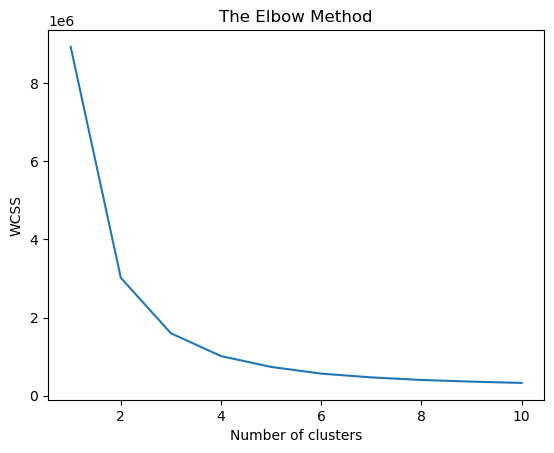

In [4]:
# Metodo del Codo para encontrar el numero optimo de clusters
from sklearn.cluster import KMeans
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(selected_data)
    wcss.append(kmeans.inertia_)

# Grafica de la suma de las distancias
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [5]:
# Creando el k-Means para los 5 grupos encontrados
kmeans = KMeans(n_clusters =4, init = 'k-means++', random_state = 42) #k-means++ acelera la convergencia, respecto de random
y_kmeans = kmeans.fit_predict(selected_data)

In [6]:
y_kmeans

array([1, 1, 0, ..., 3, 2, 2])

In [7]:
bd['pred']=y_kmeans
bd

,FECHA,PROVINCIA,GENERO_PERSONA_SIT_VIOLENCIA,EDAD,PAIS_NACIMIENTO,VIOLENCIA_FISICA,VIOLENCIA_PSICOLOGICA,VIOLENCIA_SEXUAL,VIOLENCIA_ECONOMICA,VIOLENCIA_SIMBOLICA,...,VIOLENCIA_CONTRA_LIBERTAD_REPRODUCTIVA,VIOLENCIA_OTRAS,VINCULO_PERSONA_AGRESORA,GENERO_AGRESOR,CASO,TiPO_VIOLENCIA,LUGAR_VIOLENCIA,MOTIVO_VIOLENCIA,VINCULO_ENCODED,pred
0,2020-01-01,Tucumán,Mujer,39.0,NaN,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,Pareja,Varon,1.0,VIOLENCIA_FISICA,VIOLENCIA_DOMESTICA,VIOLENCIA_OTRAS,3,1
1,2020-01-01,Buenos Aires,Mujer,39.0,NaN,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,Ex pareja,Varon,1.0,VIOLENCIA_FISICA,VIOLENCIA_DOMESTICA,VIOLENCIA_OTRAS,0,1
2,2020-01-01,Buenos Aires,Mujer,22.0,Argentina,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,Ex pareja,Varon,1.0,VIOLENCIA_FISICA,VIOLENCIA_DOMESTICA,VIOLENCIA_OTRAS,0,0
3,2020-01-01,Buenos Aires,Mujer,53.0,NaN,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,Pareja,Varon,1.0,VIOLENCIA_PSICOLOGICA,VIOLENCIA_DOMESTICA,VIOLENCIA_OTRAS,3,3
4,2020-01-01,Buenos Aires,Mujer,38.0,Argentina,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,Pareja,Varon,1.0,VIOLENCIA_FISICA,VIOLENCIA_DOMESTICA,VIOLENCIA_OTRAS,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73488,2022-09-30,Buenos Aires,Mujer,37.0,NaN,1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,Pareja,Varon,1.0,VIOLENCIA_FISICA,VIOLENCIA_DOMESTICA,VIOLENCIA_OTRAS,3,2
73489,2022-09-30,Buenos Aires,Mujer,53.0,Argentina,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,Pareja,Varon,1.0,VIOLENCIA_FISICA,VIOLENCIA_DOMESTICA,VIOLENCIA_SEXUAL,3,3
73491,2022-09-30,Buenos Aires,Mujer,52.0,Argentina,0.0,1.0,1.0,0.0,1.0,...,0.0,0.0,Ex pareja,Varon,1.0,VIOLENCIA_PSICOLOGICA,VIOLENCIA_DOMESTICA,VIOLENCIA_SEXUAL,0,3
73492,2022-09-30,Buenos Aires,Mujer,29.0,NaN,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,Pareja,Varon,1.0,VIOLENCIA_PSICOLOGICA,VIOLENCIA_DOMESTICA,VIOLENCIA_OTRAS,3,2


In [8]:
bd.groupby(['pred']).mean()

C:\Users\garro\AppData\Local\Temp\ipykernel_23576\3338535747.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  bd.groupby(['pred']).mean()


,EDAD,VIOLENCIA_FISICA,VIOLENCIA_PSICOLOGICA,VIOLENCIA_SEXUAL,VIOLENCIA_ECONOMICA,VIOLENCIA_SIMBOLICA,VIOLENCIA_DOMESTICA,VIOLENCIA_INSTITUCIONAL,VIOLENCIA_LABORAL,VIOLENCIA_CONTRA_LIBERTAD_REPRODUCTIVA,VIOLENCIA_OTRAS,CASO,VINCULO_ENCODED
pred,,,,,,,,,,,,,
0,22.703801,0.712407,0.932728,0.169639,0.345255,0.318814,0.893426,0.015539,0.010853,0.006120,0.028448,1.0,1.448195
1,42.619979,0.635802,0.959457,0.124987,0.428823,0.347576,0.916729,0.015184,0.016676,0.003303,0.018434,1.0,1.453383
2,32.210375,0.685542,0.954000,0.125417,0.426792,0.326083,0.923667,0.015750,0.011542,0.004917,0.017250,1.0,1.395042
3,56.087290,0.580059,0.955459,0.111225,0.400358,0.392679,0.892871,0.016127,0.020351,0.001664,0.026494,1.0,1.623192


In [9]:
# Visualizacion grafica de los clusters
plt.scatter(selected_data[y_kmeans == 0, 0], selected_data[y_kmeans == 0, 1], s = 100, c = 'red', label = 'Cluster 1')
plt.scatter(selected_data[y_kmeans == 1, 0], selected_data[y_kmeans == 1, 1], s = 100, c = 'blue', label = 'Cluster 2')
plt.scatter(selected_data[y_kmeans == 2, 0], selected_data[y_kmeans == 2, 1], s = 100, c = 'green', label = 'Cluster 3')
plt.scatter(selected_data[y_kmeans == 3, 0], selected_data[y_kmeans == 3, 1], s = 100, c = 'cyan', label = 'Cluster 4')
#plt.scatter(selected_data[y_kmeans == 4, 0], X[y_kmeans == 4, 1], s = 100, c = 'magenta', label = 'Cluster 5')

plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s = 300, c = 'yellow', label = 'Centroids')

plt.title('Clusters of customers')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.legend()
plt.show()  

InvalidIndexError: (array([False, False,  True, ..., False, False, False]), 0)